### Import Libraries

In [18]:
import torch
import matplotlib.pyplot as plt
import tiktoken
from coding_gpt2_to_predict_next_token import GPTModel

### Probabilistic sampling process

Example vocabulary considered

In [19]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

Assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits:

In [20]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)



Next token id from  logits

In [21]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


Implement probabilistic sampling process intead of argmax

In [22]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


Understanding sampling process

In [23]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sample_ids):
        print(f"{freq} X {inverse_vocab [i]}")

print_sampled_tokens(probas)

73 X closer
0 X every
0 X effort
582 X forward
2 X inches
0 X moves
0 X pizza
343 X toward


### DECODING STRATEGY 1: TEMPERATURE SCALING

In [24]:
next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

In [25]:
probas = torch.softmax(next_token_logits2, dim=0)

print(probas)


tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])


In [26]:
probas = torch.softmax(next_token_logits3, dim=0)

print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [27]:
def softmax_with_temperature(logits,temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim =0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]



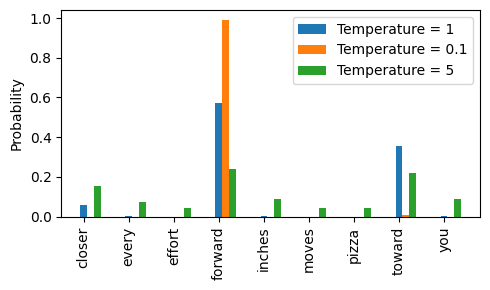

In [28]:
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores. 

In other words, using a temperature of 1 is the same as not
using any temperature scaling. 

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function. 

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often. 

This can add more variety to the
generated texts but also more often results in nonsensical text. 

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.

### Decoding strategy 2 : top-k sampling

In top-k sampling,  the sampled tokens will be restricted  to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.

Filter top three values from logits

In [29]:
top_k =3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Apply -inf to all other positions in logits

In [30]:
new_logits = torch.where(
    condition = next_token_logits < top_pos[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)

print(new_logits)

tensor([4.5100, 0.8900,   -inf, 6.7500, 1.6300,   -inf,   -inf, 6.2800, 1.7900])


Apply softmax

In [31]:
topk_probas = torch.softmax(new_logits, dim =0)
print(topk_probas)

tensor([0.0609, 0.0016, 0.0000, 0.5723, 0.0034, 0.0000, 0.0000, 0.3577, 0.0040])


Merge temperature scaling and top-k sampling

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling and take sample from multinomial distribution
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified


In [32]:
def generate(model,idx,max_new_tokens,context_size, temperature = 0.0, top_k = None, es_id =None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits [:,-1,:]

        # New: Filter logits with top_k sampling
        if top_k is not None:

            top_logits, _ = torch.topk(logits,top_k)
            min_value = top_logits[:,-1]
            logits = torch.where( logits < min_value, torch.tensor(float("-inf")).to(logits.device), logits)
            


        # New: Apply temperature scaling    
        if temperature > 0.0:

            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim =-1) # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (batch_size, 1)


        # Otherwise same as before: get idx of the vocab entry with the highest logits valu

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) # (batch_size, 1)

        if idx_next.item() == es_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break
        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [33]:
def text_to_token_ids (text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

tokenizer = tiktoken.get_encoding("gpt2")

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 768, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)


token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you filler accuse squareSplitux Results Variety tick Institution Ips goof Electrical minesophonGROUP
